#  Churn Prediction 

Nowadays, industry faces fierce com-petition in satisfying its customers. The role of churn prediction system is not only restricted to accurately predict churners but also to interpret customer churn behavior. In this Project we will predict amount of churn where '1' indicates Churn and '0' indicates stay.We will build this using AWS Sagemaker Notebook environment.
Outline:

1. Data Extraction
2. Data Visualisation
3. Data Preprocessing
4. Data Modeling
5. Performance

## 1. Data Extraction

In [ ]:
import os, sagemaker,boto3, math, sys,json, urllib.request
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sagemaker import get_execution_role
from IPython.display import Image
from IPython.display import display
from sagemaker.predictor import csv_serializer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,  GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression


In [ ]:
role=get_execution_role

In [ ]:
prefix='sagemaker/Demo-churn-prediction'

In [ ]:
my_region=boto3.session.Session().region_name

In [ ]:
bucket_names = 'sagemaker-ap-southeast-1-337937410634' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_names)
    else: 
      s3.create_bucket(Bucket=bucket_names, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 error:  An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [ ]:
try:
  urllib.request.urlretrieve ("https://s3.console.aws.amazon.com/s3/object/sagemaker-ap-southeast-1-337937410634?region=ap-southeast-1&prefix=Churn+Modeling.csv")
  print('Success: downloaded churn.csv.')
except Exception as e:
  print('Data load error: ',e)

try:
  model_data = pd.read_csv('./Churn Modeling.csv',index_col=0)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded churn.csv.
Success: Data loaded into dataframe.


In [ ]:
model_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
model_data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
model_data.shape

(10000, 13)

In [ ]:
model_data.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
model_data.nunique()

CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [ ]:
model_data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

##2. Data Visualization

In [ ]:
feature=['HasCrCard','NumOfProducts','Exited','IsActiveMember','Geography','Gender']

In [ ]:
char=['Geography','Gender']

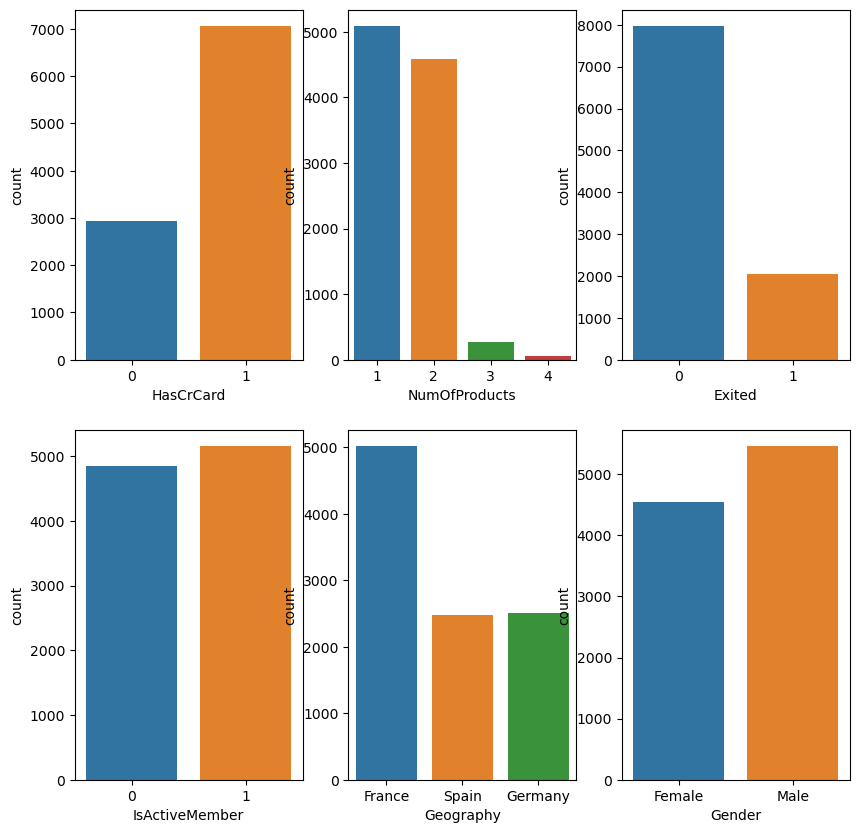

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0,6):
    plt.subplot(2,3,i+1)
    sn.countplot(x=model_data[feature[i]], data=model_data)

In [ ]:
cors=model_data.corr()

/tmp/ipykernel_9070/3271494179.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cors=model_data.corr()


<AxesSubplot: >

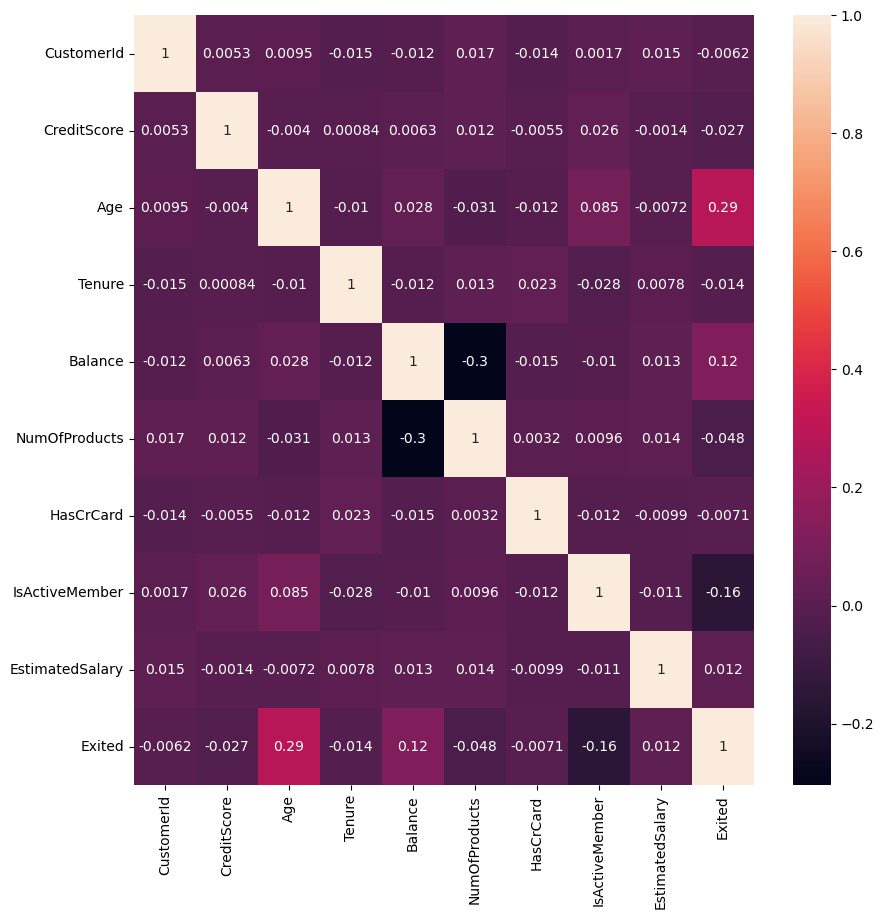

In [ ]:
plt.figure(figsize=(10,10))
sn.heatmap(cors, annot=True)

##3. Data Preprocessing

In [ ]:
gen=pd.get_dummies(model_data['Gender'])
geo=pd.get_dummies(model_data['Geography'])

In [ ]:
dfs=pd.concat([model_data,gen,geo], axis=1)

In [ ]:
dfs.drop(['Geography','Gender'], axis=1, inplace=True)

In [ ]:
dfs.drop(['Surname','CustomerId'], axis=1, inplace=True)

In [ ]:
dfs.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Female,Male,France,Germany,Spain
RowNumber,,,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,1,0,1,0,0
2,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0,0,1
3,502,42,8,159660.80,3,1,0,113931.57,1,1,0,1,0,0
4,699,39,1,0.00,2,0,0,93826.63,0,1,0,1,0,0
5,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0,0,1


##4. Data modeling using 5 machine learning classifier model.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
x=dfs.drop(['Exited'],axis=1)
y=dfs['Exited']

In [ ]:
mm=MinMaxScaler()
x_mm=mm.fit_transform(x)

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y, test_size=0.3, random_state=10)

In [ ]:
xtrain1,xtest1,ytrain1,ytest1=train_test_split(x_mm,y, test_size=0.3, random_state=10)

In [ ]:
rf=RandomForestClassifier()
dt=DecisionTreeClassifier()
lr=LogisticRegression()
ab=AdaBoostClassifier()
gb=GradientBoostingClassifier()

model_rf=rf.fit(xtrain,ytrain)
model_dt=dt.fit(xtrain,ytrain)
model_lr=lr.fit(xtrain,ytrain)
model_ab=ab.fit(xtrain,ytrain)
model_gb=gb.fit(xtrain,ytrain)


model_rf_mm=rf.fit(xtrain1,ytrain1)
model_dt_mm=dt.fit(xtrain1,ytrain1)
model_lr_mm=lr.fit(xtrain1,ytrain1)
model_ab_mm=ab.fit(xtrain1,ytrain1)
model_gb_mm=gb.fit(xtrain1,ytrain1)


In [ ]:
predict_rf=model_rf.predict(xtest)
predict_dt=model_dt.predict(xtest)
predict_lr=model_lr.predict(xtest)
predict_ab=model_ab.predict(xtest)
predict_gb=model_gb.predict(xtest)


predict_rf_mm=model_rf_mm.predict(xtest1)
predict_dt_mm=model_dt_mm.predict(xtest1)
predict_lr_mm=model_lr_mm.predict(xtest1)
predict_ab_mm=model_ab_mm.predict(xtest1)
predict_gb_mm=model_gb_mm.predict(xtest1)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [ ]:
print('Random Forest Score :')
print(classification_report(ytest,predict_rf))
print('Decision Tree Score :')
print(classification_report(ytest,predict_dt))
print('Logistic Regression Score :')
print(classification_report(ytest,predict_lr))
print('Ada Boost Score :')
print(classification_report(ytest,predict_ab))
print('Gradient Boosr Score :')
print(classification_report(ytest,predict_gb))


Random Forest Score :
              precision    recall  f1-score   support

           0       0.91      0.03      0.06      2380
           1       0.21      0.99      0.35       620

    accuracy                           0.23      3000
   macro avg       0.56      0.51      0.21      3000
weighted avg       0.76      0.23      0.12      3000

Decision Tree Score :
              precision    recall  f1-score   support

           0       0.85      0.55      0.67      2380
           1       0.27      0.64      0.38       620

    accuracy                           0.57      3000
   macro avg       0.56      0.59      0.53      3000
weighted avg       0.73      0.57      0.61      3000

Logistic Regression Score :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2380
           1       0.21      1.00      0.34       620

    accuracy                           0.21      3000
   macro avg       0.10      0.50      0.17      3000
we

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [ ]:
print('Random Forest Score :')
print(classification_report(ytest1,predict_rf_mm))
print('Decision Tree Score :')
print(classification_report(ytest1,predict_dt_mm))
print('Logistic Regression Score :')
print(classification_report(ytest1,predict_lr_mm))
print('Ada Boost Score :')
print(classification_report(ytest1,predict_ab_mm))
print('Gradient Boosr Score :')
print(classification_report(ytest1,predict_gb_mm))


Random Forest Score :
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2380
           1       0.75      0.43      0.55       620

    accuracy                           0.85      3000
   macro avg       0.81      0.70      0.73      3000
weighted avg       0.84      0.85      0.84      3000

Decision Tree Score :
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2380
           1       0.49      0.50      0.50       620

    accuracy                           0.79      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.79      0.79      0.79      3000

Logistic Regression Score :
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      2380
           1       0.56      0.20      0.29       620

    accuracy                           0.80      3000
   macro avg       0.69      0.58      0.59      3000
we

As we can see, Gradient Boost using MinMax hits the highest score for overall performance score. Here we choose Gradient boost as our predictor model.

In [ ]:
for i in range(0,10):
    a=model_gb_mm.predict(xtest1[[i+1]])
    if a==1:
        print('Customer ',i+1, 'predict Customer Churning')
    else :
        print('Customer ',i+1, 'predict potential Retention')


Customer  1 predict potential Retention
Customer  2 predict Customer Churning
Customer  3 predict potential Retention
Customer  4 predict Customer Churning
Customer  5 predict potential Retention
Customer  6 predict potential Retention
Customer  7 predict potential Retention
Customer  8 predict potential Retention
Customer  9 predict Customer Churning
Customer  10 predict potential Retention
